In [1]:
# importing files
!pip install ReliefF
!pip install sklearn
!pip install delayed
!pip install imblearn
import numpy as np
import pandas as pd
from scipy import stats
import random
import networkx as nx
from scipy.io import arff
from scipy.stats import kstest
from scipy.stats.mstats import gmean 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from matplotlib import pyplot
import collections
from sklearn.utils import resample
from sklearn.preprocessing import normalize
import itertools
from networkx.algorithms.bipartite.matrix import biadjacency_matrix
from networkx.algorithms.bipartite import sets as bipartite_sets
import tensorflow as tf
from tensorflow import keras
from ReliefF import ReliefF
from tensorflow.keras import layers
import tensorflow_probability as tfp
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from tensorflow.python.framework import ops

     |████████████████████████████████| 51kB 2.7MB/s 
  Created wheel for ReliefF: filename=ReliefF-0.1.2-cp37-none-any.whl size=6306 sha256=d0b9b428d591ae04f401c34a4107b28e80e326f914cf82a32e8926e24f2b41b8
  Stored in directory: /root/.cache/pip/wheels/1c/9e/51/59ca638520794c9e0155d592b9f8c579f80cc29cbaf1de0f45
Successfully built ReliefF
     |████████████████████████████████| 71kB 3.2MB/s 
     |████████████████████████████████| 81kB 3.7MB/s 


In [2]:
current_dataset = ''
current_technique = ''
results={}
results['AUC'] = {}
results['GM'] = {}
results['BL'] = {}
imbl_techniques = []


In [3]:
def import_data(filename):
    # import total dataset
    data = pd.read_csv(filename)
    data = data.to_numpy()
    # get a list of column names
    #headers = list(data.columns.values)

    # separate into independent and dependent variables
    #x = data[headers[:-1]]
    #y = data[headers[-1:]].values.ravel()
    x, y = data[:,0:data.shape[1]-1],data[:,-1]
    return x, y

In [4]:
# Load csv
def loadcsv(filename1, filename2) :
    train_data = pd.read_csv(filename1)
    train_data = train_data.to_numpy()
    test_data = pd.read_csv(filename2)
    test_data = test_data.to_numpy()
    return train_data, test_data

In [5]:
# Perfomance Measures
def performance_measures(Y_expected,Y_predicted):

    # TN, FP, FN, TP = confusion_matrix(Y_expected,Y_predicted).ravel()
      
    # # Sensitivity, hit rate, recall, or true positive rate
    # TPR = TP/(TP+FN)
    # # Specificity or true negative rate
    # TNR = TN/(TN+FP) 
    # # Precision or positive predictive value
    # PPV = TP/(TP+FP)
    # # Negative predictive value
    # NPV = TN/(TN+FN)
    # # Fall out or false positive rate
    # FPR = FP/(FP+TN)
    # # False negative rate
    # FNR = FN/(TP+FN)
    # # False discovery rate
    # FDR = FP/(TP+FP)
    # # Overall accuracy
    # ACC = (TP+TN)/(TP+FP+FN+TN)

    AUC = roc_auc_score(Y_expected,Y_predicted)
    FPR, TPR, thresholds = roc_curve(Y_expected,Y_predicted)
    TNR = 1 - FPR
    # auc = metrics.roc_auc_score(Y_expected,Y_predicted) 
    # acc_score = accuracy_score(Y_expected, Y_predicted)
    # prec_score = precision_score(Y_expected, Y_predicted)
    # recal_Score = recall_score(Y_expected, Y_predicted)
    # f1_score =  f1_score(Y_expected, Y_predicted)
    
    #Geometric Mean of TPR and TNR
    GM = gmean([TPR,TNR])

    # calculate the g-mean for each threshold
    #gmeans = sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(GM)
    #print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

    arr = []
    arr.append(FPR)
    arr.append(TPR)

    # Euclidian distance between the pair (T.P.R, F.P.R) to a optimal value of the pair (T.P.R, F.P.R)
    BL = np.linalg.norm(np.array((0,1))-np.array((FPR[ix],TPR[ix])))
    # BL = 0

    return AUC, FPR, TPR, GM[ix], BL

In [6]:
def plot_roc_curve(auc,fpr,tpr):
    pyplot.plot([0,1], [0,1], linestyle='--')
    pyplot.plot(fpr,tpr,label="ROC Curve Area ="+str(round(auc,4)))
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')

    pyplot.legend(loc=4)
    pyplot.show()
    pass

In [7]:
# Oversampling using Random
def oversampling_Random(X_train,Y_train):
    from imblearn.over_sampling import RandomOverSampler
    ros = RandomOverSampler(random_state=0)
    X_train, Y_train = ros.fit_resample(X_train, Y_train)
    return X_train, Y_train

In [8]:
# Oversampling using ADASYN
def oversampling_ADASYN(X_train,Y_train):
    from imblearn.over_sampling import ADASYN
    adasy = ADASYN()
    X_train, Y_train = adasy.fit_resample(X_train, Y_train)
    return X_train, Y_train

In [9]:
# Oversampling using SMOTE
def oversampling_SMOTE(X_train,Y_train):
    from imblearn.over_sampling import SMOTE
    sm = SMOTE()
    X_train, Y_train = sm.fit_resample(X_train, Y_train)
    return X_train, Y_train

In [10]:
# Oversampling using Borderline SMOTE
def oversampling_BorderlineSMOTE(X_train,Y_train):
    from imblearn.over_sampling import BorderlineSMOTE
    bsm = BorderlineSMOTE()
    X_train, Y_train = bsm.fit_resample(X_train, Y_train)
    return X_train, Y_train

In [11]:
# Oversampling using K-means SMOTE
def oversampling_KmeansSMOTE(X_train,Y_train):
    from imblearn.over_sampling import KMeansSMOTE
    sm = KMeansSMOTE() 
    X_train, Y_train = sm.fit_resample(X_train, Y_train)
    return X_train, Y_train

In [12]:
# Undersampling using Cluster Centroids
def undersampling_ClusterCentroids(X_train,Y_train):
    from imblearn.under_sampling import ClusterCentroids 
    cc = ClusterCentroids(random_state=0)
    X_train, Y_train = cc.fit_resample(X_train, Y_train)
    return X_train, Y_train

In [13]:
# Undersampling using RandomUnderSampler
def undersampling_RandomUnderSampler(X_train,Y_train):
    from imblearn.under_sampling import RandomUnderSampler 
    rus = RandomUnderSampler(random_state=0)
    X_train, Y_train = rus.fit_resample(X_train, Y_train)
    return X_train, Y_train

In [14]:
# Undersampling using NearMiss-3 Algorithm
def undersampling_NearMiss(X_train,Y_train):
    from imblearn.under_sampling import NearMiss
    sm = NearMiss(version=3)
    X_train, Y_train = sm.fit_resample(X_train, Y_train)
    return X_train, Y_train

In [15]:
# Undersampling using TomekLinks
def undersampling_TomekLinks(X_train,Y_train):
    from imblearn.under_sampling import TomekLinks 
    sm = TomekLinks()
    X_train, Y_train = sm.fit_resample(X_train, Y_train)
    return X_train, Y_train

In [16]:
# Undersampling using EditedNearestNeighbours
def undersampling_EditedNN(X_train,Y_train):
    from imblearn.under_sampling import EditedNearestNeighbours 
    enn = EditedNearestNeighbours()
    X_train, Y_train = enn.fit_resample(X_train, Y_train)
    return X_train, Y_train

In [17]:
# Undersampling using AllKNN
def undersampling_AllKNN(X_train,Y_train):
    from imblearn.under_sampling import AllKNN 
    aknn = AllKNN()
    X_train, Y_train = aknn.fit_resample(X_train, Y_train)
    return X_train, Y_train

In [18]:
# Undersampling using Condensed Nearest Neighbour
def undersampling_CondNN(X_train,Y_train):
    from imblearn.under_sampling import CondensedNearestNeighbour 
    sm = CondensedNearestNeighbour()
    X_train, Y_train = sm.fit_resample(X_train, Y_train)
    return X_train, Y_train

In [19]:
# Combination of Oversampling and Undersampling using SMOTETomek
def sampling_SMOTETomek(X_train,Y_train):
    from imblearn.combine import SMOTETomek 
    sm = SMOTETomek()
    X_train, Y_train = sm.fit_resample(X_train, Y_train)
    return X_train, Y_train

In [20]:
# Combination of Oversampling and Undersampling using SMOTEENN
def sampling_SMOTEENN(X_train,Y_train):
    from imblearn.combine import SMOTEENN 
    sm = SMOTEENN()
    X_train, Y_train = sm.fit_resample(X_train, Y_train)
    return X_train, Y_train

In [21]:
def Logistic_Regression(X,Y) :
    from sklearn.linear_model import LogisticRegression
    
    # blank lists to store predicted values and actual values
    predicted_y = []
    expected_y = []

    auc_all = []
    skf = StratifiedKFold(n_splits=10)
 
    for train_index, test_index in skf.split(X, Y):
        clf = LogisticRegression(max_iter = 10000, solver = 'liblinear')
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        clf.fit(X_train, Y_train) 
        Y_pred_test=clf.predict(X_test)
        Y_pred_train=clf.predict(X_train)
        Y_pred_probs = clf.predict_proba(X_test)
        Y_pred_probs = Y_pred_probs[:,1]
      
        # store result from classification
        predicted_y.extend(Y_pred_probs)

        # store expected result for this specific fold
        expected_y.extend(Y_test)

        #auc = metrics.roc_auc_score(Y_test,Y_pred_probs)
      
        #auc_all.append(auc)
        
    #print(performance_measures(expected_y,predicted_y))
    auc = metrics.roc_auc_score(expected_y,predicted_y)    
    return auc

In [22]:
#Neural Network Function
def NN(X_train, Y_train, X_test, Y_test,EPOCHS) :
    model = keras.Sequential([
        layers.Dense(18,kernel_regularizer=keras.regularizers.l2(0.001), activation='relu', input_shape=[X_train.shape[1]]),
        layers.Dense(15,kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'),
        layers.Dense(10,kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'),
        layers.Dense(5,kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'),
        layers.Dense(1,activation='sigmoid')
     ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss=tf.keras.losses.Poisson(),
                  optimizer=optimizer,
                  metrics=[tf.keras.metrics.AUC()])
    
    history = model.fit(X_train, Y_train, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0)
    loss, auc = model.evaluate(X_test,Y_test, verbose=0)

    Y_pred_test=model.predict(X_test).flatten()
    
    Y_pred_train=model.predict(X_train).flatten()
    
    Y_pred_probs = model.predict_proba(X_test)

    
    return auc,Y_test, Y_pred_probs

In [23]:
def ksplit_NN(x,y) :
  
     global current_technique 
     results[current_dataset] = {}
     results[current_dataset][current_technique] = {}

     skf = StratifiedKFold(n_splits=10)
     
     # blank lists to store predicted values and actual values
     predicted_y = []
     expected_y = []
     
     nn_arr = []
     nn_fpr = []
     nn_tpr = []

     #print(x)
     #print(y)
     for train_index, test_index in skf.split(x, y):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        auc,Y_test, Y_pred_probs = NN(X_train,y_train,X_test,y_test,10)

        #fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_probs)
        #i1 = get_pdpf(fpr,tpr)
        #nn_fpr.append(fpr[i1])
        #nn_tpr.append(tpr[i1])
        nn_arr.append(auc)

        # store result from classification
        predicted_y.extend(Y_pred_probs)

        # store expected result for this specific fold
        expected_y.extend(Y_test)

        
     auc, fpr, tpr, gm, bl = performance_measures(expected_y,predicted_y)
     #fpr, tpr, thresholds = roc_curve(expected_y,predicted_y)
     
     print(current_dataset+' '+current_technique)
     plot_roc_curve(auc,fpr,tpr)
     #  print(auc +' '+gm +' '+bl)
     print(f'AUC= {auc} GM={gm} BL={bl}')

     results['AUC'][current_dataset].append(round(auc,4))
     results['GM'][current_dataset].append(round(gm*100,2))
     results['BL'][current_dataset].append(round(bl*100,2))

     return auc

MAIN FUNCTIONS

In [24]:
def main_step_ImbalancedLearner(X_source, Y_source) :
 

    global current_technique

    skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=False)
    #lr = Logistic_Regression(X_source,Y_source)

    #print(lr)

    #balanced_lr = Logistic_Regression(X_balanced_source,Y_balanced_source)

    #print(balanced_lr)

    # blank lists to store predicted values and actual values
    predicted_y = []
    expected_y = []

    imbl_techniques.clear()
    
    # Not Balanced NN
    current_technique='IMBALANCED'
    imbl_techniques.append(current_technique)
    ksplit_NN(X_source, Y_source)
    
    # Oversampling Random
    current_technique='ROS'
    imbl_techniques.append(current_technique)
    X_balanced_source, Y_balanced_source = oversampling_Random(X_source,Y_source)
    ksplit_NN(X_balanced_source, Y_balanced_source)

    # oversampling_SMOTE
    current_technique='SMOTE'
    imbl_techniques.append(current_technique)
    X_balanced_source, Y_balanced_source = oversampling_SMOTE(X_source,Y_source)
    ksplit_NN(X_balanced_source, Y_balanced_source)

    # oversampling_BorderlineSMOTE
    current_technique='BL-SMOTE'
    imbl_techniques.append(current_technique)
    X_balanced_source, Y_balanced_source = oversampling_BorderlineSMOTE(X_source,Y_source)
    ksplit_NN(X_balanced_source, Y_balanced_source)

    # oversampling_ADASYN
    current_technique='ADASYN'
    imbl_techniques.append(current_technique)
    X_balanced_source, Y_balanced_source = oversampling_ADASYN(X_source,Y_source)
    ksplit_NN(X_balanced_source, Y_balanced_source)

    # oversampling_KmeansSMOTE
    current_technique='KM-SMOTE'
    #imbl_techniques.append(current_technique)
    #X_balanced_source, Y_balanced_source = oversampling_KmeansSMOTE(X_source,Y_source)
    #ksplit_NN(X_balanced_source, Y_balanced_source)
    
    # undersampling_RandomUnderSampler
    current_technique='RUS'
    imbl_techniques.append(current_technique)
    X_balanced_source, Y_balanced_source = undersampling_RandomUnderSampler(X_source,Y_source)
    ksplit_NN(X_balanced_source, Y_balanced_source)

    # undersampling_ClusterCentroids
    current_technique='CC'
    imbl_techniques.append(current_technique)
    X_balanced_source, Y_balanced_source = undersampling_ClusterCentroids(X_source,Y_source)
    ksplit_NN(X_balanced_source, Y_balanced_source)

    # undersampling_NearMiss
    current_technique='NM'
    imbl_techniques.append(current_technique)
    X_balanced_source, Y_balanced_source = undersampling_NearMiss(X_source,Y_source)
    ksplit_NN(X_balanced_source, Y_balanced_source)

    # undersampling_CondNN
    current_technique='CNN'
    imbl_techniques.append(current_technique)
    X_balanced_source, Y_balanced_source = undersampling_CondNN(X_source,Y_source)
    ksplit_NN(X_balanced_source, Y_balanced_source)

    # undersampling_TomekLinks
    current_technique='TL'
    imbl_techniques.append(current_technique)
    X_balanced_source, Y_balanced_source = undersampling_TomekLinks(X_source,Y_source)
    ksplit_NN(X_balanced_source, Y_balanced_source)

    # undersampling_EditedNN
    current_technique='ENN'
    imbl_techniques.append(current_technique)
    X_balanced_source, Y_balanced_source = undersampling_EditedNN(X_source,Y_source)
    ksplit_NN(X_balanced_source, Y_balanced_source)

   
    # sampling_SMOTETomek
    current_technique='SMOTE-TL'
    imbl_techniques.append(current_technique)
    X_balanced_source, Y_balanced_source = sampling_SMOTETomek(X_source,Y_source)
    ksplit_NN(X_balanced_source, Y_balanced_source)

    # sampling_SMOTEENN
    current_technique='SMOTE-ENN'
    imbl_techniques.append(current_technique)
    X_balanced_source, Y_balanced_source = sampling_SMOTEENN(X_source,Y_source)
    ksplit_NN(X_balanced_source, Y_balanced_source)
   
    #print(nn_fpr)
    #print(nn_tpr)
      
    return 1

In [25]:
def main_ImbalancedLearner() :

    global current_dataset
    datasets = ['data_ant-1.7','data_camel-1.6','data_ivy-2.0','data_jedit-4.3','data_log4j-1.2','data_prop-6']
    all_auc = {}
    for i in range(len(datasets)) :
        file1 = datasets[i]
        current_dataset = file1
        results['AUC'][current_dataset] = []
        results['GM'][current_dataset] = []
        results['BL'][current_dataset] = []
        # get training and testing sets
        X_data, Y_data = import_data(file1+ ".csv")
        
        main_step_ImbalancedLearner(X_data,Y_data)
        # set to 10 folds
        #skf = StratifiedKFold(n_splits=10)
    
    # print(imbl_techniques)
    print(results)  
    df = pd.DataFrame(results['AUC'], index=imbl_techniques)  
    df.to_csv('auc.csv') 

    df = pd.DataFrame(results['GM'], index=imbl_techniques)  
    df.to_csv('gm.csv')  

    df = pd.DataFrame(results['BL'], index=imbl_techniques)  
    df.to_csv('bl.csv')  
    

data_ant-1.7 IMBALANCED


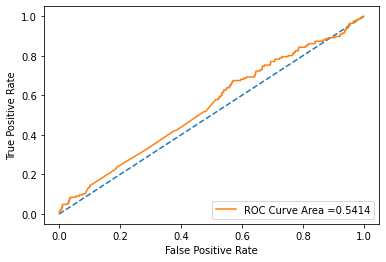

AUC= 0.541373828647925 GM=0.5378884294319163 BL=0.65731887307579
data_ant-1.7 ROS


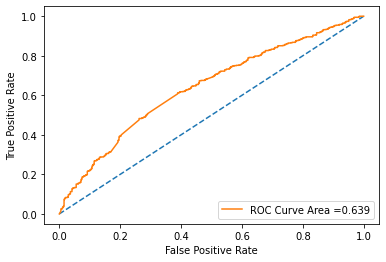

AUC= 0.6390290436921298 GM=0.611978551024119 BL=0.5487456981537842
data_ant-1.7 SMOTE


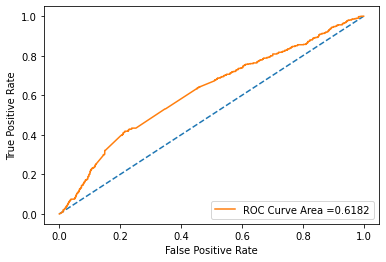

AUC= 0.6181565272955247 GM=0.5902905431626211 BL=0.5805001053396827
data_ant-1.7 BL-SMOTE


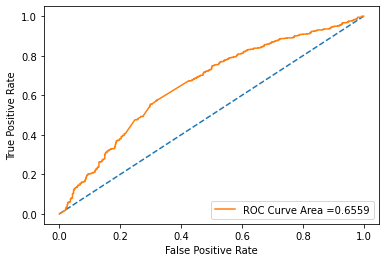

AUC= 0.6559229721257716 GM=0.6264523057020738 BL=0.530222090158431
data_ant-1.7 ADASYN


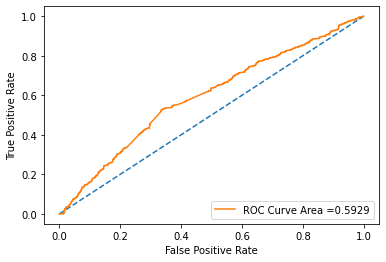

AUC= 0.5929060990338164 GM=0.5919370682375139 BL=0.5796910081461074
data_ant-1.7 RUS


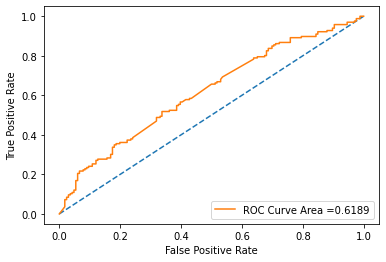

AUC= 0.6189033241399332 GM=0.5859188634114616 BL=0.5882677405172869
data_ant-1.7 CC


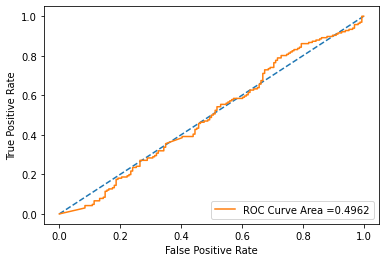

AUC= 0.49624401219335174 GM=0.5111615285685885 BL=0.6913815294170397
data_ant-1.7 NM


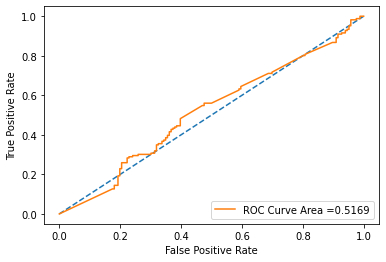

AUC= 0.5168565829583394 GM=0.5418673861649982 BL=0.6479755088927641
data_ant-1.7 CNN


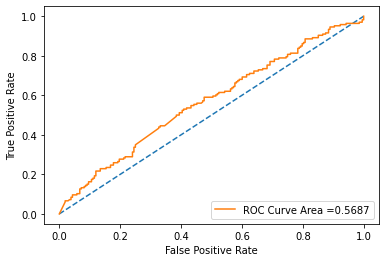

AUC= 0.5686978683966636 GM=0.559897051307668 BL=0.6227236365195864
data_ant-1.7 TL


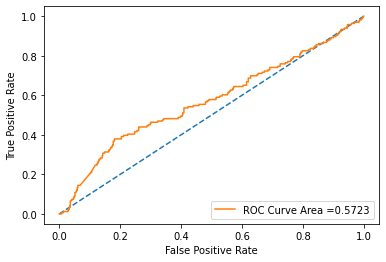

AUC= 0.5723006310958119 GM=0.5700902284878477 BL=0.6180340465592236
data_ant-1.7 ENN


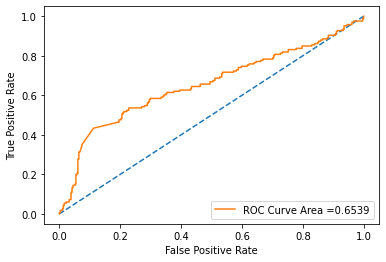

AUC= 0.65390500910394 GM=0.6432301393771545 BL=0.5169921020947027
data_ant-1.7 SMOTE-TL


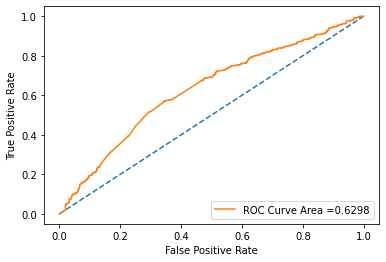

AUC= 0.6297734850871666 GM=0.6117450789241395 BL=0.5502864627958023
data_ant-1.7 SMOTE-ENN


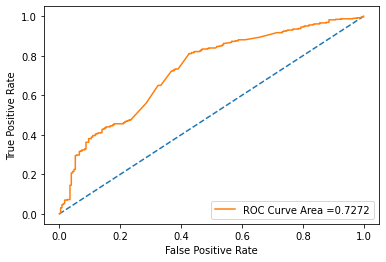

AUC= 0.72720661758022 GM=0.6825692838075322 BL=0.4655792738280709
data_camel-1.6 IMBALANCED


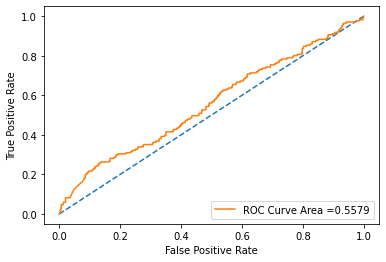

AUC= 0.5579204255254847 GM=0.5384416945427892 BL=0.6540886159213744
data_camel-1.6 ROS


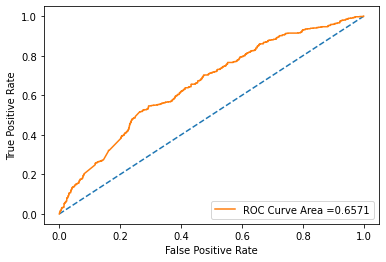

AUC= 0.6571369909660878 GM=0.6214738883352857 BL=0.5400609521600508
data_camel-1.6 SMOTE


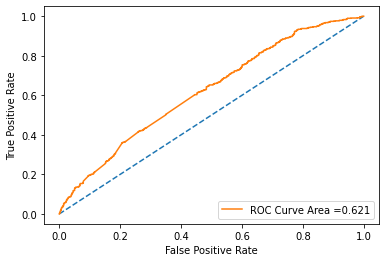

AUC= 0.621037230668563 GM=0.5790535668986135 BL=0.5958692188116964
data_camel-1.6 BL-SMOTE


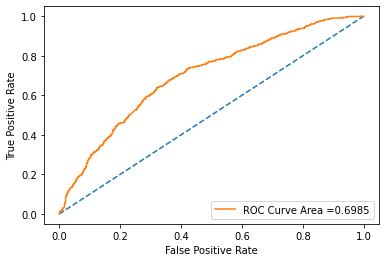

AUC= 0.6985240603863283 GM=0.6586664172136358 BL=0.4830452004092542
data_camel-1.6 ADASYN


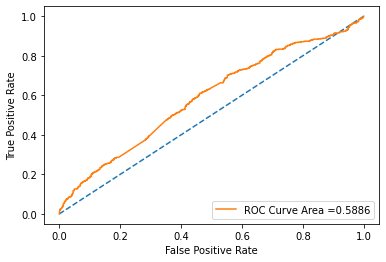

AUC= 0.5885884564878084 GM=0.5734342571883246 BL=0.603802257196837
data_camel-1.6 RUS


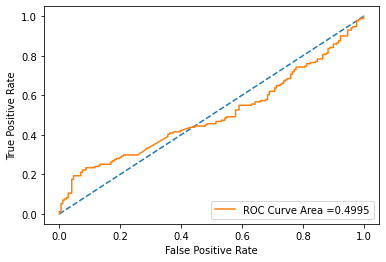

AUC= 0.4994528230908655 GM=0.5108179602788878 BL=0.6930503088157243
data_camel-1.6 CC


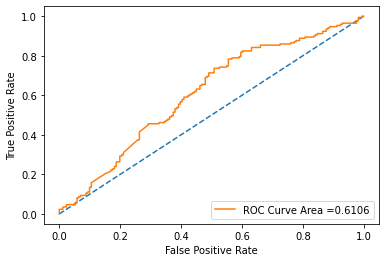

AUC= 0.6106494305940289 GM=0.6024811051784574 BL=0.5686965375798165
data_camel-1.6 NM


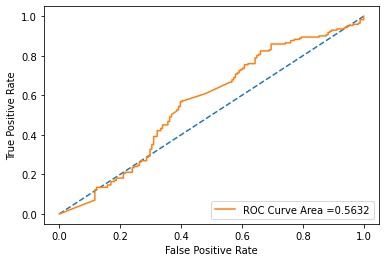

AUC= 0.5631989330050271 GM=0.5846783508748532 BL=0.5874210060279618
data_camel-1.6 CNN


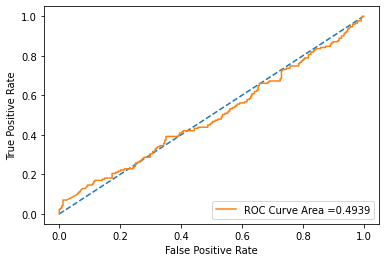

AUC= 0.49392803244670813 GM=0.5043435183045015 BL=0.7021087929004407
data_camel-1.6 TL


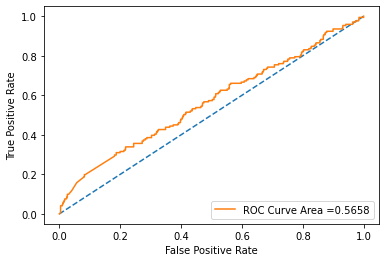

AUC= 0.5658303113463361 GM=0.5481190680180863 BL=0.6393881669192114
data_camel-1.6 ENN


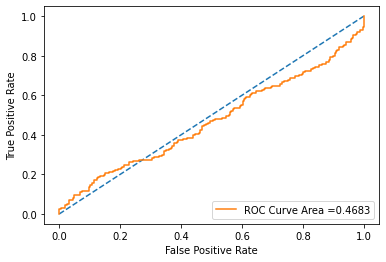

AUC= 0.46828121027205694 GM=0.48684708733646953 BL=0.7256605535623306
data_camel-1.6 SMOTE-TL


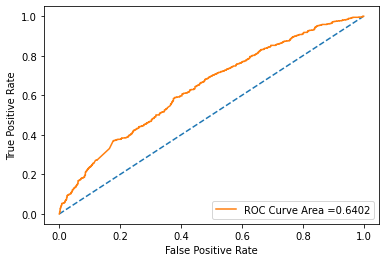

AUC= 0.6402289210389079 GM=0.6048737347873816 BL=0.5589531756636297
data_camel-1.6 SMOTE-ENN


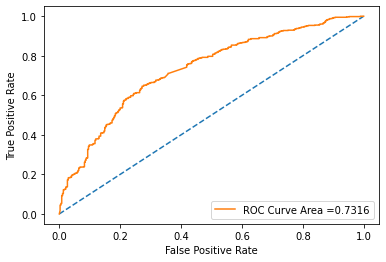

AUC= 0.7315693012600228 GM=0.6860047522035245 BL=0.44561564153948663
data_ivy-2.0 IMBALANCED


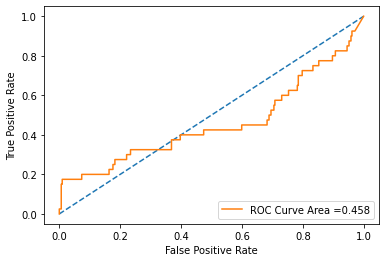

AUC= 0.4579727564102564 GM=0.49895724599742347 BL=0.7144011482755765
data_ivy-2.0 ROS


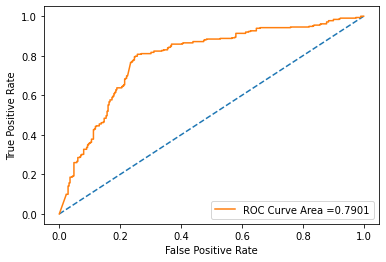

AUC= 0.7900538297172913 GM=0.7749785261388418 BL=0.3205128205128205
data_ivy-2.0 SMOTE


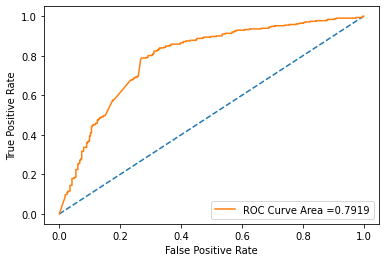

AUC= 0.7918721236028929 GM=0.7590674752304059 BL=0.3423941118224011
data_ivy-2.0 BL-SMOTE


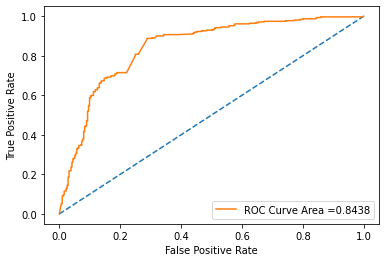

AUC= 0.8437962278106509 GM=0.7948071727246777 BL=0.30950653711262766
data_ivy-2.0 ADASYN


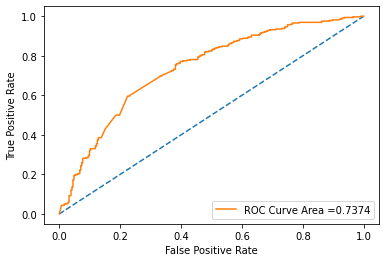

AUC= 0.7373872269705604 GM=0.6835614471124555 BL=0.4477412309965018
data_ivy-2.0 RUS


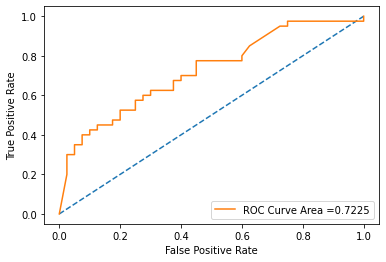

AUC= 0.7224999999999999 GM=0.6614378277661476 BL=0.4802343178074637
data_ivy-2.0 CC


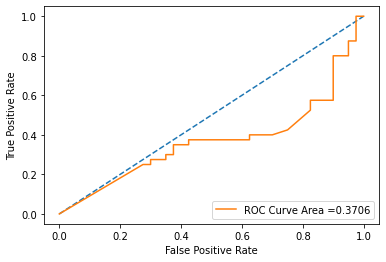

AUC= 0.37062500000000004 GM=0.4677071733467426 BL=0.7504165509901817
data_ivy-2.0 NM


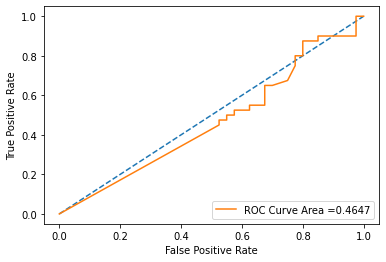

AUC= 0.4646875 GM=0.475 BL=0.7424621202458749
data_ivy-2.0 CNN


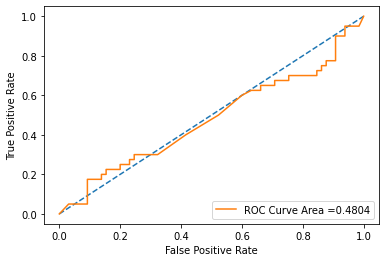

AUC= 0.4803846153846154 GM=0.48989794855663565 BL=0.7211102550927979
data_ivy-2.0 TL


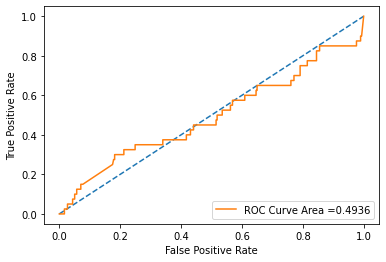

AUC= 0.4936447811447811 GM=0.5126349703196347 BL=0.6961176862597331
data_ivy-2.0 ENN


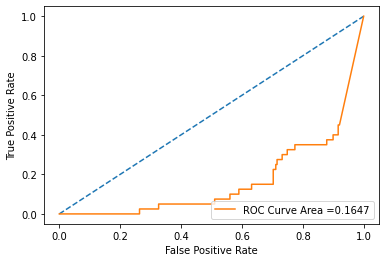

AUC= 0.16474895397489542 GM=0.28563955986346823 BL=1.0082445420192543
data_ivy-2.0 SMOTE-TL


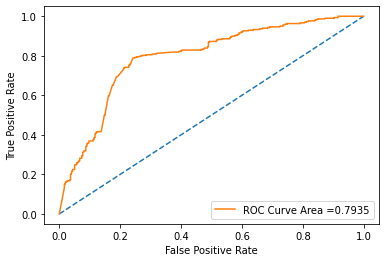

AUC= 0.7935002927796044 GM=0.773342515323538 BL=0.32104467219668403
data_ivy-2.0 SMOTE-ENN


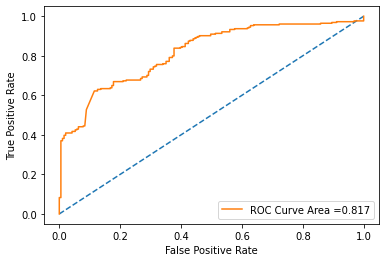

AUC= 0.8169703590716082 GM=0.7421380263999413 BL=0.39082900965401485
data_jedit-4.3 IMBALANCED


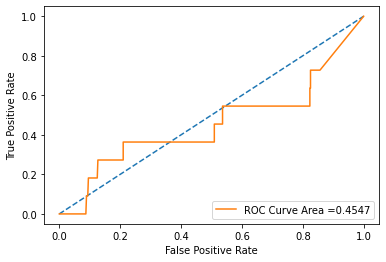

AUC= 0.45473445473445473 GM=0.5359853424117933 BL=0.6701118908879647
data_jedit-4.3 ROS


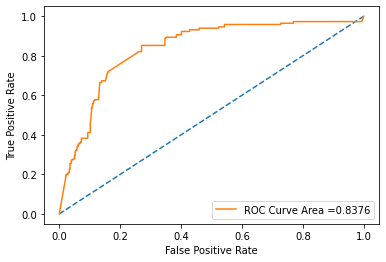

AUC= 0.8376238864804353 GM=0.7886792417321954 BL=0.30795207330015506
data_jedit-4.3 SMOTE


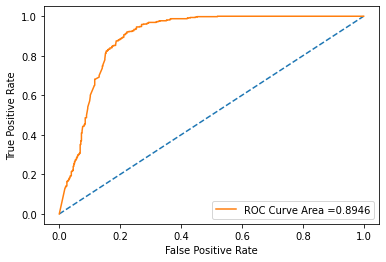

AUC= 0.8946321981665016 GM=0.8462381258246493 BL=0.23606517037986272
data_jedit-4.3 BL-SMOTE


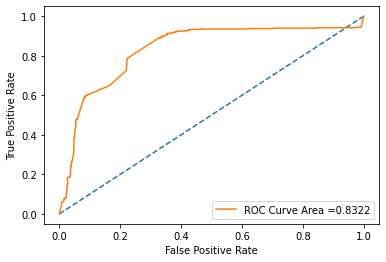

AUC= 0.8322297189241055 GM=0.7816937231048631 BL=0.30877205614865794
data_jedit-4.3 ADASYN


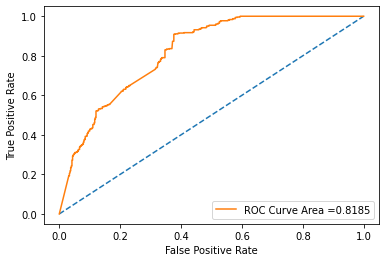

AUC= 0.8184604170081349 GM=0.7528381612642611 BL=0.3872136496287885
data_jedit-4.3 RUS


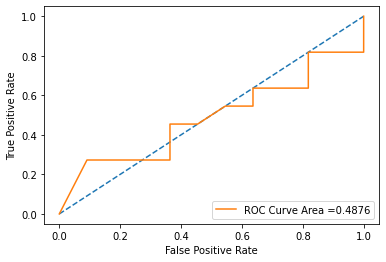

AUC= 0.4876033057851239 GM=0.5378254348272379 BL=0.6555547773570889
data_jedit-4.3 CC


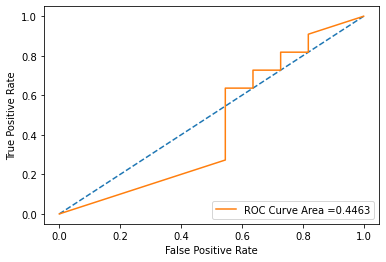

AUC= 0.44628099173553726 GM=0.5378254348272379 BL=0.6555547773570889
data_jedit-4.3 NM


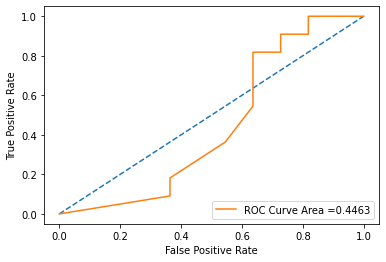

AUC= 0.4462809917355372 GM=0.5454545454545455 BL=0.6618281717527744
data_jedit-4.3 CNN


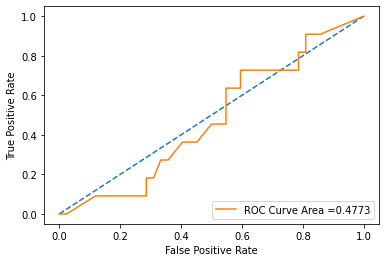

AUC= 0.47727272727272724 GM=0.5425608669746598 BL=0.6547431216224665
data_jedit-4.3 TL


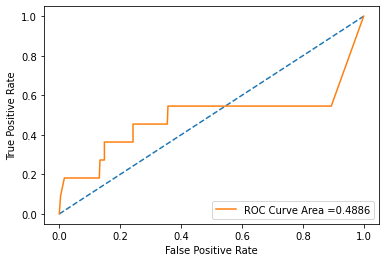

AUC= 0.48861263996963367 GM=0.5922252011990724 BL=0.5779758632251659
data_jedit-4.3 ENN


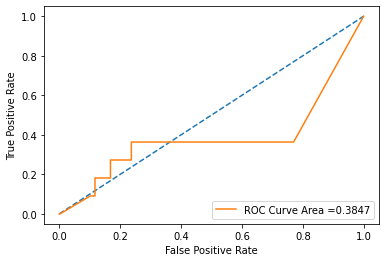

AUC= 0.3846540627514079 GM=0.5268342282947993 BL=0.6789681270487714
data_jedit-4.3 SMOTE-TL


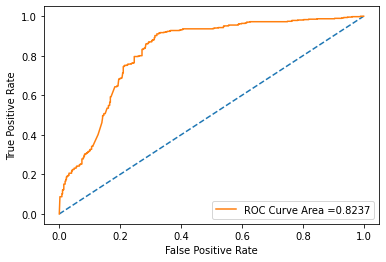

AUC= 0.8236619921475291 GM=0.786652139407858 BL=0.33276487425473267
data_jedit-4.3 SMOTE-ENN


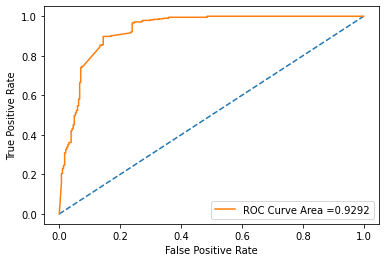

AUC= 0.9292179780252194 GM=0.8765149852017583 BL=0.17681864409992193
data_log4j-1.2 IMBALANCED


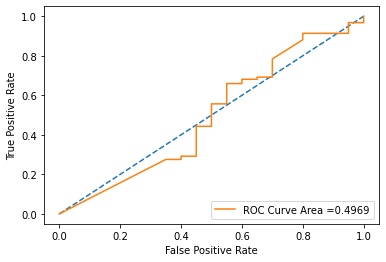

AUC= 0.49689189189189187 GM=0.5447538496942971 BL=0.646890917969671
data_log4j-1.2 ROS


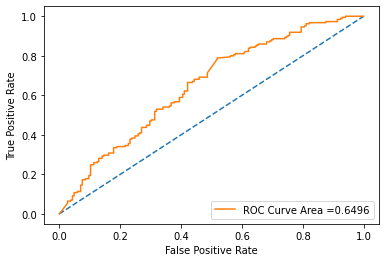

AUC= 0.6495982468955442 GM=0.6201156846760935 BL=0.5385910792251308
data_log4j-1.2 SMOTE


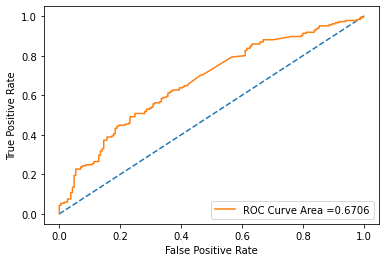

AUC= 0.6705770635500365 GM=0.6270270270270271 BL=0.5274634367769921
data_log4j-1.2 BL-SMOTE


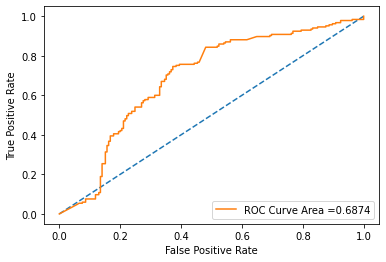

AUC= 0.6873922571219869 GM=0.6839066228728524 BL=0.4512785181565795
data_log4j-1.2 ADASYN


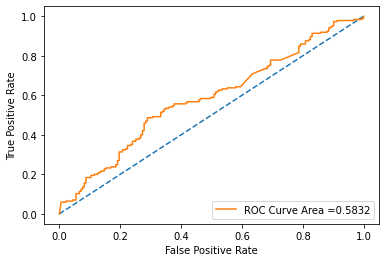

AUC= 0.5832077979618964 GM=0.5899017287848832 BL=0.5817285968616345
data_log4j-1.2 RUS


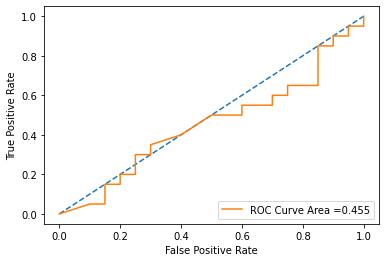

AUC= 0.45500000000000007 GM=0.5 BL=0.7071067811865476
data_log4j-1.2 CC


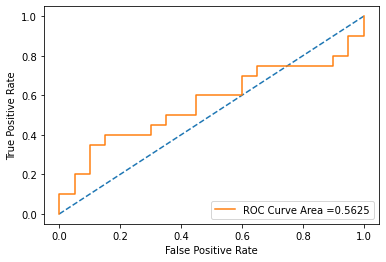

AUC= 0.5625 GM=0.58309518948453 BL=0.618465843842649
data_log4j-1.2 NM


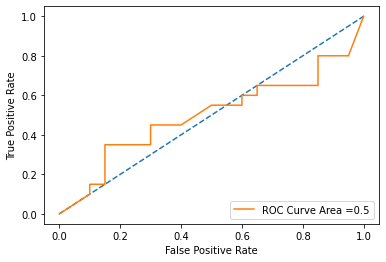

AUC= 0.5 GM=0.5612486080160911 BL=0.6264982043070835
data_log4j-1.2 CNN


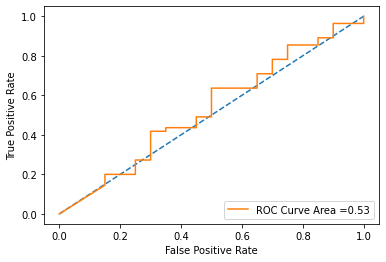

AUC= 0.53 GM=0.5640760748177662 BL=0.6182486594879747
data_log4j-1.2 TL


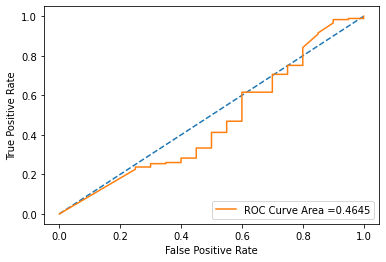

AUC= 0.46454802259887007 GM=0.4963140977403515 BL=0.7124569321320402
data_log4j-1.2 ENN


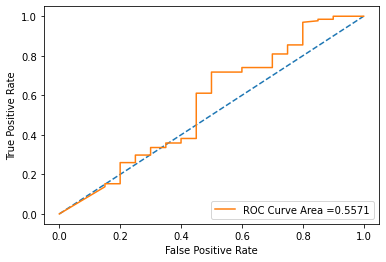

AUC= 0.5570610687022901 GM=0.5989813235437299 BL=0.5742594413238121
data_log4j-1.2 SMOTE-TL


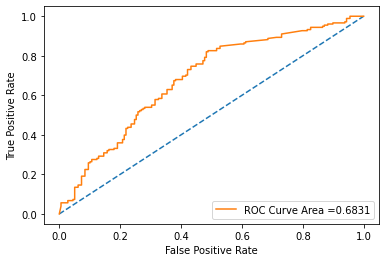

AUC= 0.6831208180785254 GM=0.6511282003889478 BL=0.5010404526180516
data_log4j-1.2 SMOTE-ENN


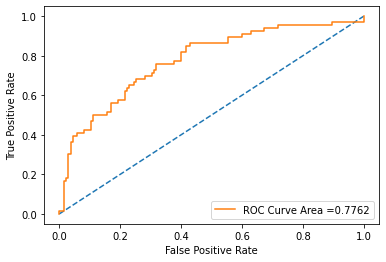

AUC= 0.7762065095398429 GM=0.7185219896476258 BL=0.4002793523955485
data_prop-6 IMBALANCED


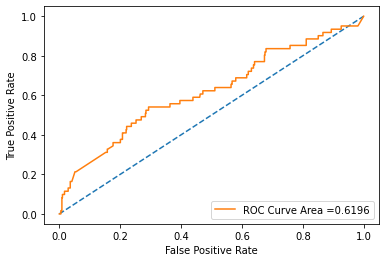

AUC= 0.619604645277395 GM=0.6183101603376253 BL=0.5447266077820948
data_prop-6 ROS


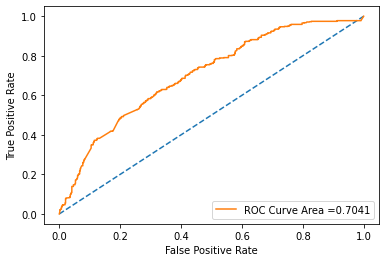

AUC= 0.7041078116679269 GM=0.647634966280025 BL=0.4991924668201671
data_prop-6 SMOTE


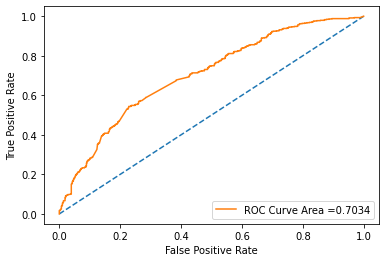

AUC= 0.7034370044338004 GM=0.6496488799322538 BL=0.4991305781588383
data_prop-6 BL-SMOTE


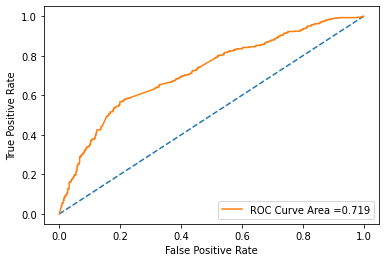

AUC= 0.7190332726272401 GM=0.6753879767999842 BL=0.4703020037893026
data_prop-6 ADASYN


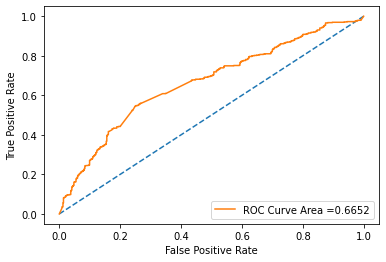

AUC= 0.6652120824490508 GM=0.6407941986229332 BL=0.5146667961264879
data_prop-6 RUS


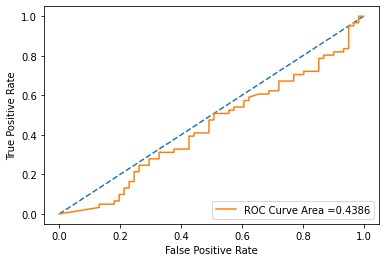

AUC= 0.4385917764041924 GM=0.49993280924514444 BL=0.7072017904958358
data_prop-6 CC


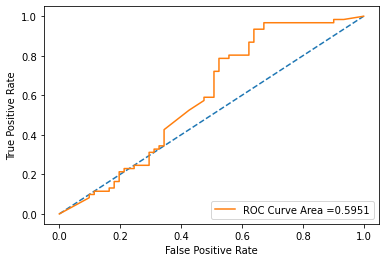

AUC= 0.5951357162053212 GM=0.6116314133172993 BL=0.5662267553826408
data_prop-6 NM


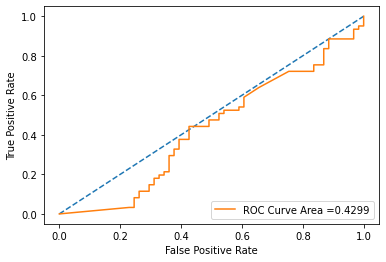

AUC= 0.4298575651706531 GM=0.5039483983258819 BL=0.7016699855420555
data_prop-6 CNN


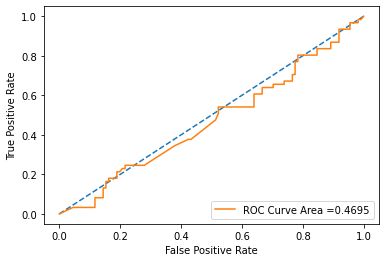

AUC= 0.4695022891744204 GM=0.5082395968592811 BL=0.695504015798883
data_prop-6 TL


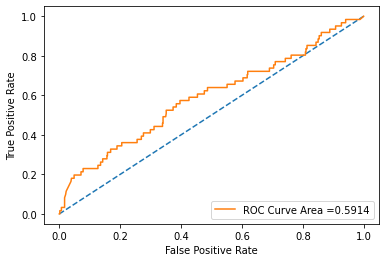

AUC= 0.5914041339985745 GM=0.5884369282529078 BL=0.5821521135069798
data_prop-6 ENN


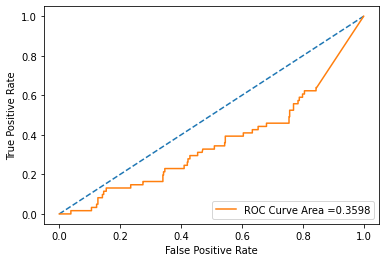

AUC= 0.3598066058988667 GM=0.4228918962178588 BL=0.8157404690278681
data_prop-6 SMOTE-TL


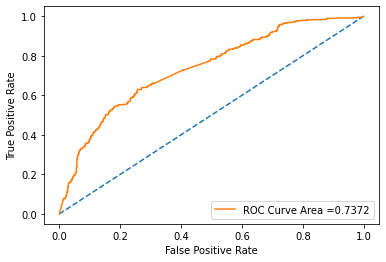

AUC= 0.7372197392521027 GM=0.683910750633617 BL=0.4509441426022548
data_prop-6 SMOTE-ENN


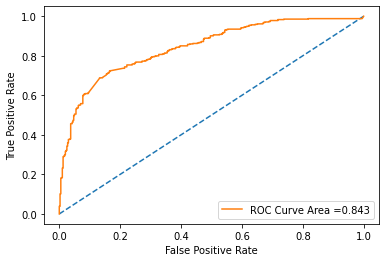

AUC= 0.8430463695832882 GM=0.7768935286645872 BL=0.32208834144361126
{'AUC': {'data_ant-1.7': [0.5414, 0.639, 0.6182, 0.6559, 0.5929, 0.6189, 0.4962, 0.5169, 0.5687, 0.5723, 0.6539, 0.6298, 0.7272], 'data_camel-1.6': [0.5579, 0.6571, 0.621, 0.6985, 0.5886, 0.4995, 0.6106, 0.5632, 0.4939, 0.5658, 0.4683, 0.6402, 0.7316], 'data_ivy-2.0': [0.458, 0.7901, 0.7919, 0.8438, 0.7374, 0.7225, 0.3706, 0.4647, 0.4804, 0.4936, 0.1647, 0.7935, 0.817], 'data_jedit-4.3': [0.4547, 0.8376, 0.8946, 0.8322, 0.8185, 0.4876, 0.4463, 0.4463, 0.4773, 0.4886, 0.3847, 0.8237, 0.9292], 'data_log4j-1.2': [0.4969, 0.6496, 0.6706, 0.6874, 0.5832, 0.455, 0.5625, 0.5, 0.53, 0.4645, 0.5571, 0.6831, 0.7762], 'data_prop-6': [0.6196, 0.7041, 0.7034, 0.719, 0.6652, 0.4386, 0.5951, 0.4299, 0.4695, 0.5914, 0.3598, 0.7372, 0.843]}, 'GM': {'data_ant-1.7': [53.79, 61.2, 59.03, 62.65, 59.19, 58.59, 51.12, 54.19, 55.99, 57.01, 64.32, 61.17, 68.26], 'data_camel-1.6': [53.84, 62.15, 57.91, 65.87, 57.34, 51.08, 60.25, 58.47, 50.43,

In [26]:
import warnings
warnings.filterwarnings('ignore')
all_auc = main_ImbalancedLearner()

In [27]:
    df = pd.DataFrame(results['GM'], index=imbl_techniques)  
    print(df.to_markdown())  

    df = pd.DataFrame(results['BL'], index=imbl_techniques)  
    print(df.to_markdown())  

|            |   data_ant-1.7 |   data_camel-1.6 |   data_ivy-2.0 |   data_jedit-4.3 |   data_log4j-1.2 |   data_prop-6 |
|:-----------|---------------:|-----------------:|---------------:|-----------------:|-----------------:|--------------:|
| IMBALANCED |          53.79 |            53.84 |          49.9  |            53.6  |            54.48 |         61.83 |
| ROS        |          61.2  |            62.15 |          77.5  |            78.87 |            62.01 |         64.76 |
| SMOTE      |          59.03 |            57.91 |          75.91 |            84.62 |            62.7  |         64.96 |
| BL-SMOTE   |          62.65 |            65.87 |          79.48 |            78.17 |            68.39 |         67.54 |
| ADASYN     |          59.19 |            57.34 |          68.36 |            75.28 |            58.99 |         64.08 |
| RUS        |          58.59 |            51.08 |          66.14 |            53.78 |            50    |         49.99 |
| CC         |          

In [29]:
    df = pd.DataFrame(results['AUC'], index=imbl_techniques)  
    df.to_csv('auc.csv') 

    df = pd.DataFrame(results['GM'], index=imbl_techniques)  
    df.to_csv('gm.csv')  

    df = pd.DataFrame(results['BL'], index=imbl_techniques)  
    df.to_csv('bl.csv')   

In [30]:
    df = pd.DataFrame(results['AUC'], index=imbl_techniques)  
    print(df.to_markdown())  

|            |   data_ant-1.7 |   data_camel-1.6 |   data_ivy-2.0 |   data_jedit-4.3 |   data_log4j-1.2 |   data_prop-6 |
|:-----------|---------------:|-----------------:|---------------:|-----------------:|-----------------:|--------------:|
| IMBALANCED |         0.5414 |           0.5579 |         0.458  |           0.4547 |           0.4969 |        0.6196 |
| ROS        |         0.639  |           0.6571 |         0.7901 |           0.8376 |           0.6496 |        0.7041 |
| SMOTE      |         0.6182 |           0.621  |         0.7919 |           0.8946 |           0.6706 |        0.7034 |
| BL-SMOTE   |         0.6559 |           0.6985 |         0.8438 |           0.8322 |           0.6874 |        0.719  |
| ADASYN     |         0.5929 |           0.5886 |         0.7374 |           0.8185 |           0.5832 |        0.6652 |
| RUS        |         0.6189 |           0.4995 |         0.7225 |           0.4876 |           0.455  |        0.4386 |
| CC         |         0